### Convolutional Neural Network to predict a future GHI on image inputs (Part 2 Inference)

This notebook continues from were the training part left off. As such the trained model in part 1 is loaded and executed on different data from the one from training. Some functions and handling of data are performed in the same way as in part 1, so refer to that notebook for details on each.

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Flatten, Conv2D, TimeDistributed
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, TimeSeriesSplit
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
# Define the lag time in minutes

t_lag = 120

t_fix = 0

The trained model can be loaded with this single command:

In [3]:
# Load the model

model = tf.keras.models.load_model('model.h5', custom_objects={'mse': MeanSquaredError()})

In [4]:
# the same default data used during training

global_max_B02= 1.2507925033569336
global_min_B02= 0.00031746001332066953
global_max_B05= 1.2688876390457153
global_min_B05= 0.0
global_max_B13= 319.7626953125
global_min_B13= 184.5653839111328

In [5]:
def make_rgb_images(image_group, target_size=(40, 40)):

    ds_B02 = xr.open_dataset(image_group['B02'])
    image_B02 = ds_B02['CMI'].values
    max_B02 = max(global_max_B02, np.max(image_B02))
    min_B02 = min(global_min_B02, np.min(image_B02))
    normalized_B02  = (image_B02 - min_B02) / (max_B02 - min_B02)

    # ds_B05 = xr.open_dataset(image_group['B05'])
    # image_B05 = ds_B05['CMI'].values
    # max_B05 = max(global_max_B05, np.max(image_B05))
    # min_B05 = min(global_min_B05, np.min(image_B05))
    # normalized_B05  = (image_B05 - min_B05) / (max_B05 - min_B05)

    # ds_B13 = xr.open_dataset(image_group['B13'])
    # image_B13 = ds_B13['CMI'].values
    # max_B13 = max(global_max_B13, np.max(image_B13))
    # min_B13 = min(global_min_B13, np.min(image_B13))
    # normalized_B13  = (image_B13 - min_B13) / (max_B13 - min_B13)

    rgb_image = np.stack([normalized_B02, normalized_B02, normalized_B02], axis=-1)
    image_final = cv2.resize(rgb_image, target_size)

    return image_final


Make sure to adjust the path to the correct test data folder (should be a different folder than the one from training)

In [6]:
direccion = 'D:/Downloads/comprimidos/'
carpeta_imagenes = 'Test_months'

carpeta_resultados = 'carpeta_resultados_test'
image_folder = os.path.join(direccion, carpeta_imagenes)
image_files = sorted([os.path.join(image_folder, i) for i in os.listdir(image_folder) if i.endswith('.nc')])

In [7]:
# Store the filtered image paths and their timestamps

imagenes_filtradas = []  
# Process only images between 5:00 a.m. and 18:30
for nombre_imagen in os.listdir(image_folder):
    if nombre_imagen.startswith('OR_ABI-L2-CMIPF-M6C02_G16_'):
        fecha_hora_str = nombre_imagen.split('_')[3][1:15] 
        year = fecha_hora_str[:4]
        day_of_year = fecha_hora_str[4:7]
        hour = fecha_hora_str[7:9]
        minute = fecha_hora_str[9:11]
        
        # Convert to datetime object
        fecha_hora = datetime.strptime(f"{year} {day_of_year} {hour} {minute}", "%Y %j %H %M") - timedelta(hours=5)
        hora = fecha_hora.time()
        hora_inicio = datetime.strptime('05:00', '%H:%M').time()
        hora_fin = datetime.strptime('18:30', '%H:%M').time()
        # hora_inicio = datetime.strptime('00:01', '%H:%M').time()
        # hora_fin = datetime.strptime('23:59', '%H:%M').time()
        
        # Filter images by time
        if hora >= hora_inicio and hora <= hora_fin:
            ruta_completa = os.path.join(image_folder, nombre_imagen)
            imagenes_filtradas.append((ruta_completa, fecha_hora))

print(f"Número total de archivos de imagen filtrados: {len(imagenes_filtradas)}")


imagenes_filtradas_rgb = {}
missing_dates = []
for imagen in imagenes_filtradas:
    date_loc = imagen[0].split('_')[-3][1:12]
    def get_nc_from_band(band):
        if band < 10:
            band_str = 'M6C0' + str(band)
        else:
            band_str = 'M6C' + str(band)
        ncs_file = [f'{image_folder}/{i}' 
            for i in os.listdir(image_folder) 
            if i.endswith('.nc') 
            and band_str in i
            and date_loc in i
            ]
        return ncs_file
    ncs_B02 = imagen[0]
    datetime_obj = imagen[1]


    imagenes_filtradas_rgb[date_loc] = {
        'B02': ncs_B02,
        'Datetime': datetime_obj
        }
     
lista_de_fechas = [entry['Datetime'] for entry in imagenes_filtradas_rgb.values()]

Número total de archivos de imagen filtrados: 847


In [8]:
# Load and process the data
df = pd.read_csv('Datos_completos_comma.csv')
df['t'] = pd.to_datetime(df['t'], utc=True)
df.set_index('t', inplace=True)
df.index = df.index - pd.DateOffset(hours=5)

lista_de_fechas_utc = pd.to_datetime(lista_de_fechas).tz_localize('UTC', nonexistent='NaT', ambiguous='NaT')

matching_dates = lista_de_fechas_utc + pd.Timedelta(minutes=t_fix)
df_orig = df[df.index.isin(matching_dates)]
df_orig.reset_index(inplace=True)
missing_data_orig = df_orig[df_orig['GHI'].isna()]['t'] - pd.Timedelta(minutes=t_fix) 

lagged_dates = lista_de_fechas_utc - pd.Timedelta(minutes=t_lag)
df_lag = df[df.index.isin(lagged_dates)]
df_lag.reset_index(inplace=True)
missing_data_lag = df_lag[df_lag['GHI'].isna()]['t'] + pd.Timedelta(minutes=t_lag) 

combined_missing_data = pd.concat([missing_data_lag, missing_data_orig]).drop_duplicates().sort_values()
filtered_lista_de_fechas_utc = lista_de_fechas_utc[~lista_de_fechas_utc.isin(combined_missing_data)]

lagged_dates = filtered_lista_de_fechas_utc - pd.Timedelta(minutes=t_lag)
matching_dates = filtered_lista_de_fechas_utc - pd.Timedelta(minutes=t_fix)

df_orig = df[df.index.isin(matching_dates)]
df_orig.reset_index(inplace=True)

df_lag = df[df.index.isin(lagged_dates)]
df_lag.reset_index(inplace=True)

# Scale the GHI variable
scaler = MinMaxScaler()
df_lag.loc[:, 'GHI'] = scaler.fit_transform(df_lag[['GHI']])
df_orig.loc[:, 'GHI'] = scaler.fit_transform(df_orig[['GHI']])


df_orig['hour_fraction'] = df_orig['t'].dt.hour + df_orig['t'].dt.minute / 60
df_lag['hour_fraction'] = df_lag['t'].dt.hour + df_lag['t'].dt.minute / 60

# Compute sine and cosine of the time in fractional hours
df_orig['DoY Sin'] = np.sin(df_orig['hour_fraction'] * 2 * np.pi / 24)
df_orig['DoY Cos'] = np.cos(df_orig['hour_fraction'] * 2 * np.pi / 24)

df_lag['DoY Sin'] = np.sin(df_lag['hour_fraction'] * 2 * np.pi / 24)
df_lag['DoY Cos'] = np.cos(df_lag['hour_fraction'] * 2 * np.pi / 24)

# Select required columns
columnas = ['t', 'GHI', 'DoY Sin', 'DoY Cos']
df_lag = df_lag[columnas]
df_orig = df_orig[columnas]

# Create the numeric variables and the output variable for the model
numericas = ['GHI','DoY Sin','DoY Cos']
X_test_num = df_orig[numericas].values
salida = ['GHI']
y_test = df_lag[salida].values

# Convert filtered_lista_de_fechas_utc to a set for faster lookup
filtered_set = set(filtered_lista_de_fechas_utc)

# Create a new dictionary after filtering based on 'Datetime'
filtered_imagenes_filtradas_rgb = {
    key: value for key, value in imagenes_filtradas_rgb.items()
    if pd.Timestamp(value['Datetime']).tz_localize('UTC') in filtered_set
}

# Print or use the filtered dictionary
len(filtered_imagenes_filtradas_rgb)

import pytz

image_tensors = []

for n_element in filtered_imagenes_filtradas_rgb:

    image_tensor = make_rgb_images(filtered_imagenes_filtradas_rgb[n_element], target_size=(64,64))
    image_tensors.append(image_tensor)

X_test_img = np.array(image_tensors)
print(f"Formato de tensor_images: {X_test_img.shape}")


C:\Users\rodhe\AppData\Local\Temp\ipykernel_13932\1407494179.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orig['hour_fraction'] = df_orig['t'].dt.hour + df_orig['t'].dt.minute / 60
C:\Users\rodhe\AppData\Local\Temp\ipykernel_13932\1407494179.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lag['hour_fraction'] = df_lag['t'].dt.hour + df_lag['t'].dt.minute / 60
C:\Users\rodhe\AppData\Local\Temp\ipykernel_13932\1407494179.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Formato de tensor_images: (847, 64, 64, 3)


In [9]:
# Confirm shapes
print(f"Training images shape: {X_test_img.shape}")
print(f"Training numerical data shape: {X_test_num.shape}")
print(f"Training GHI shape: {y_test.shape}")

Training images shape: (847, 64, 64, 3)
Training numerical data shape: (847, 3)
Training GHI shape: (847, 1)


In [10]:
# Evaluate the model on the test set
test_loss = model.evaluate([X_test_img, X_test_num], y_test)
print(f"Test Loss (MSE): {test_loss}")


d:\Downloads\Test_goes\GOES_env\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'numerical_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0137
Test Loss (MSE): 0.013937320560216904


In [11]:
# Make predictions on the test set
predictions = model.predict([X_test_img, X_test_num])

# Display the first few predictions along with the actual GHI values
for i in range(5):
    print(f"Predicted GHI: {predictions[i][0]}, Actual GHI: {y_test[i]}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Predicted GHI: -0.006668763235211372, Actual GHI: [4.71894434e-05]
Predicted GHI: -0.0061595626175403595, Actual GHI: [2.21379027e-05]
Predicted GHI: -0.02280271239578724, Actual GHI: [4.71769741e-05]
Predicted GHI: 0.010586708784103394, Actual GHI: [0.01573863]
Predicted GHI: 0.07434019446372986, Actual GHI: [0.05432643]


In this example the test data was from the months of july and august, the results are as follows:

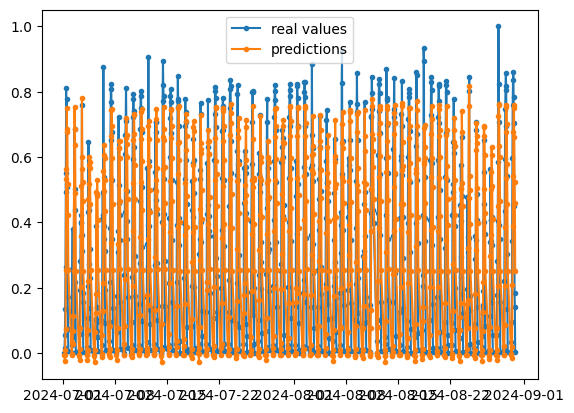

In [12]:
import matplotlib.pyplot as plt

plt.plot(df_orig['t'].values, X_test_num[:,0], '.-')
plt.plot(df_orig['t'].values, predictions, '.-')

plt.legend(['real values', 'predictions'])

To better view the results a zoom in on a random week is displayed in the following plot:

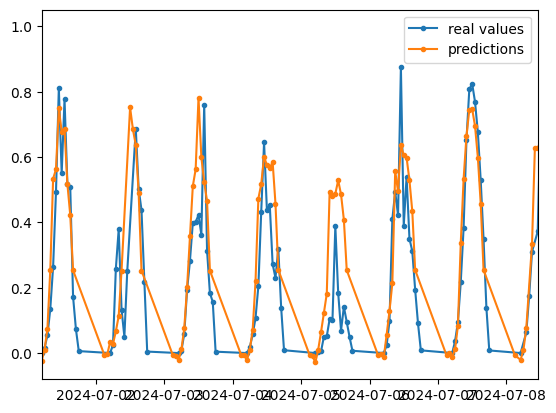

In [13]:
import matplotlib.pyplot as plt


plt.plot(df_orig['t'].values, X_test_num[:,0], '.-')
plt.plot(df_lag['t'].values, predictions, '.-')
plt.xlim([df_orig['t'].values[0], df_orig['t'].values[100]]) 
plt.legend(['real values', 'predictions'])

In [14]:
# plt.plot(X_test_num)

A correlation plot can be generated:

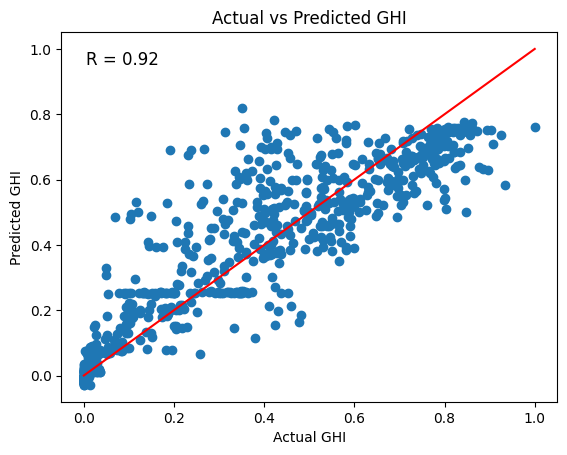

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient (r)
r_value, _ = pearsonr(y_test[:, 0], predictions[:, 0])

# Create the scatter plot with the perfect prediction line
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')  # Line for perfect predictions
plt.xlabel('Actual GHI')
plt.ylabel('Predicted GHI')
plt.title('Actual vs Predicted GHI')
plt.text(0.05, 0.95, f'R = {r_value:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

In [16]:
# Evaluation metrics

from sklearn.metrics import mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.08017266916001901
Root Mean Squared Error (RMSE): 0.11805642812299735
R² Score: 0.8370610861622757


The data can be saved to a dataframe or exported to excel for easier handling.

In [17]:
df_final = pd.DataFrame({
    'Original Time': df_orig['t'].values,
    'Lagged Time': df_lag['t'].values,
    'X Test Num (Column 0)': X_test_num[:, 0],
    'y Test': y_test[:,0],
    'Predictions': predictions[:,0]
})

# Displaying the DataFrame
df_final

# Export to excel
excel_filename = 'df_final_output.xlsx'  
df_final.to_excel(excel_filename, index=False)
print(f"DataFrame saved to {excel_filename}")

DataFrame saved to df_final_output.xlsx


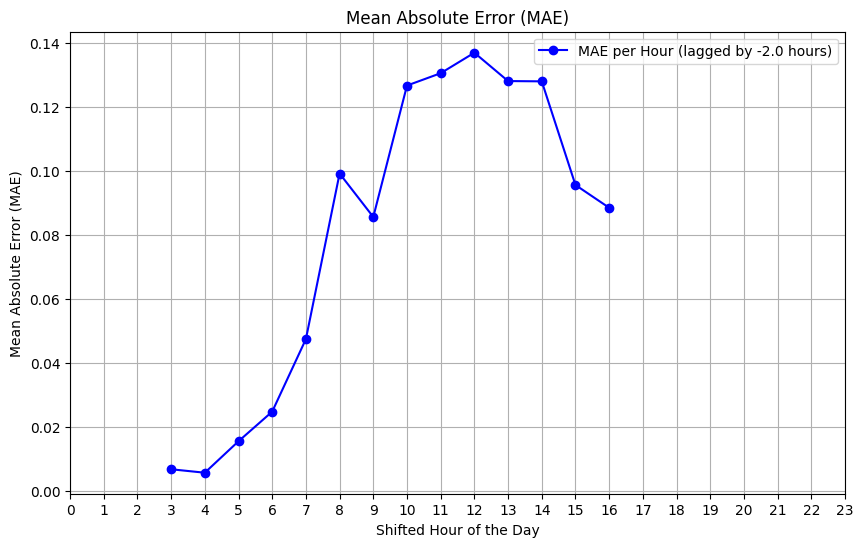

In [22]:
n = -t_lag/60  
# Step 1: Extract the hour from the 'Original Time' column
df_final['Hour'] = pd.to_datetime(df_final['Original Time']).dt.hour

# Step 2: Group by 'Hour' and calculate MAE for each hour
mae_per_hour = df_final.groupby('Hour').apply(lambda x: mean_absolute_error(x['y Test'], x['Predictions']), include_groups=False)

# # Step 3: Shift the hours by the lagged amount 'n'
shifted_hours = (mae_per_hour.index + n) % 24  # Shift and handle 24-hour wrap around
mae_per_hour.index = shifted_hours  # Update the index with shifted hours

# Step 4: Plot the shifted MAE for each hour of the day
plt.figure(figsize=(10, 6))
plt.plot(mae_per_hour.index, mae_per_hour, marker='o', linestyle='-', color='b', label=f'MAE per Hour (lagged by {n} hours)')
plt.xlabel('Shifted Hour of the Day')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'Mean Absolute Error (MAE)')
plt.grid(True)
plt.xticks(range(0, 24))  # Ensure all hours are shown on the x-axis
plt.legend()
plt.show()


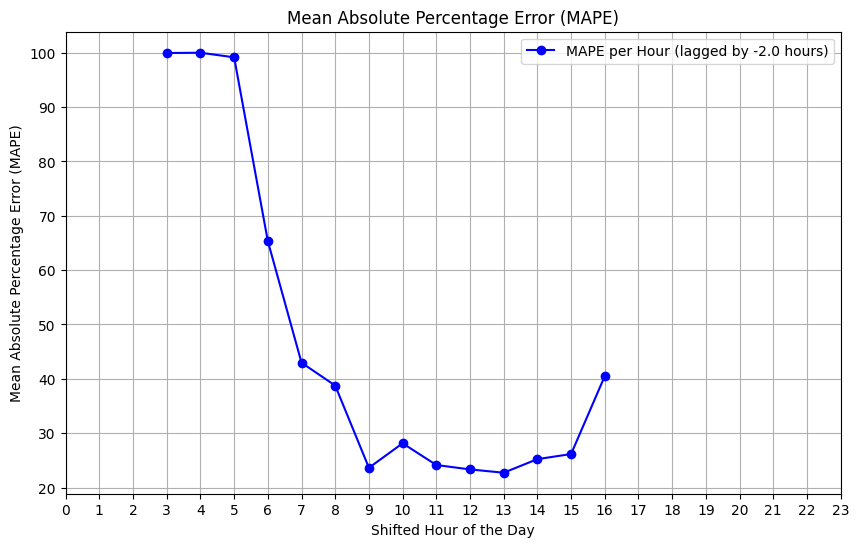

In [23]:
# Custom function to calculate MAPE with capping at 100%
def capped_mape(y_true, y_pred):
    percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
    percentage_errors = np.where(percentage_errors > 100, 100, percentage_errors)  # Cap at 100%
    return np.mean(percentage_errors)

n = -t_lag / 60  # Shift in hours
# Step 1: Extract the hour from the 'Original Time' column
df_final['Hour'] = pd.to_datetime(df_final['Original Time']).dt.hour

# Step 2: Group by 'Hour' and calculate MAPE for each hour with capping
mape_per_hour = df_final.groupby('Hour').apply(lambda x: capped_mape(x['y Test'], x['Predictions']), include_groups=False)

# Step 3: Shift the hours by the lagged amount 'n'
shifted_hours = (mape_per_hour.index + n) % 24  # Shift and handle 24-hour wrap around
mape_per_hour.index = shifted_hours  # Update the index with shifted hours

# Step 4: Plot the shifted MAPE for each hour of the day
plt.figure(figsize=(10, 6))
plt.plot(mape_per_hour.index, mape_per_hour, marker='o', linestyle='-', color='b', label=f'MAPE per Hour (lagged by {n} hours)')
plt.xlabel('Shifted Hour of the Day')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.grid(True)
plt.xticks(range(0, 24))  # Ensure all hours are shown on the x-axis
plt.legend()
plt.show()